In [1]:
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt

from estimators import bootstrap
import analysis

%matplotlib inline


In [2]:
borders = analysis.load_data("data/jigsaw_borders")
no_borders = analysis.load_data("data/jigsaw")
simulation = analysis.load_data("data/both")

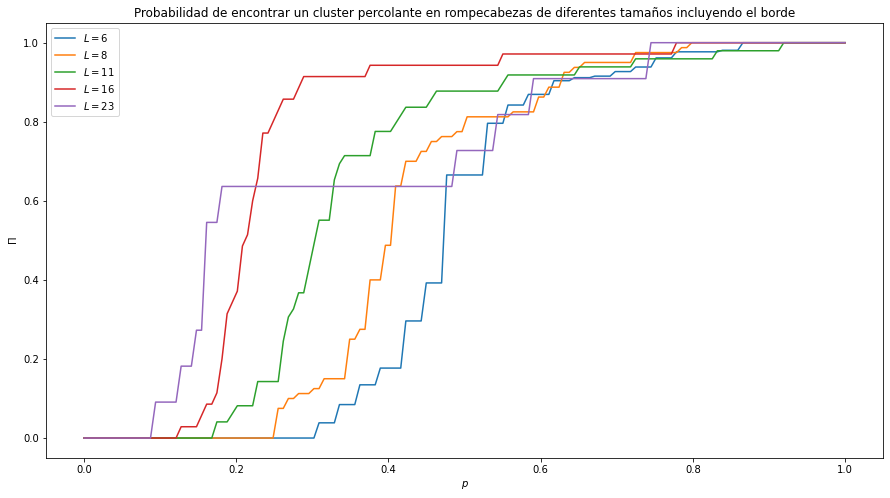

In [3]:
plt.figure(figsize=(15, 8))

for size in sorted(borders):

    steps, prob = analysis.get_pi_curve(borders[size])

    plt.plot(steps, prob, label=rf"$L = {size}$")

plt.xlabel(r"$p$")
plt.ylabel(r"$\Pi$")
plt.title(
    "Probabilidad de encontrar un cluster percolante en rompecabezas de diferentes tamaños incluyendo el borde"
)
plt.legend()

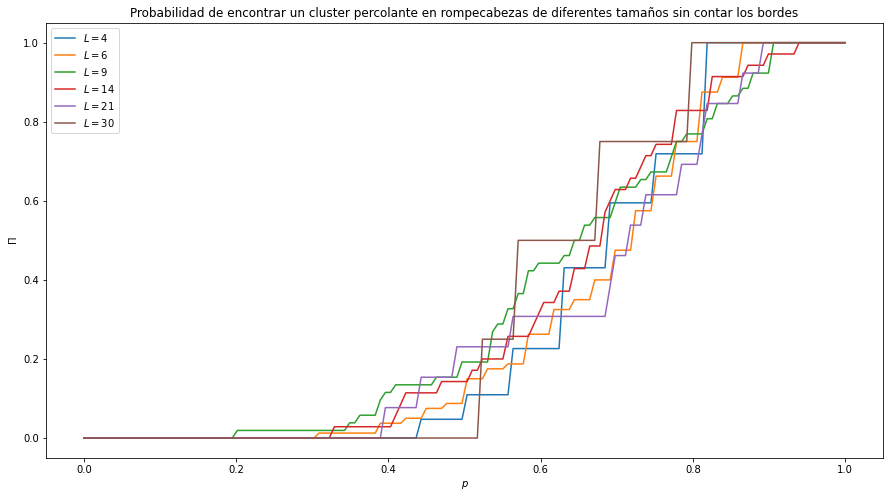

In [4]:
plt.figure(figsize=(15, 8))

for size in sorted(no_borders):

    steps, prob = analysis.get_pi_curve(no_borders[size])

    plt.plot(steps, prob, label=rf"$L = {size}$")

plt.xlabel(r"$p$")
plt.ylabel(r"$\Pi$")
plt.title(
    "Probabilidad de encontrar un cluster percolante en rompecabezas de diferentes tamaños sin contar los bordes"
)
plt.legend()

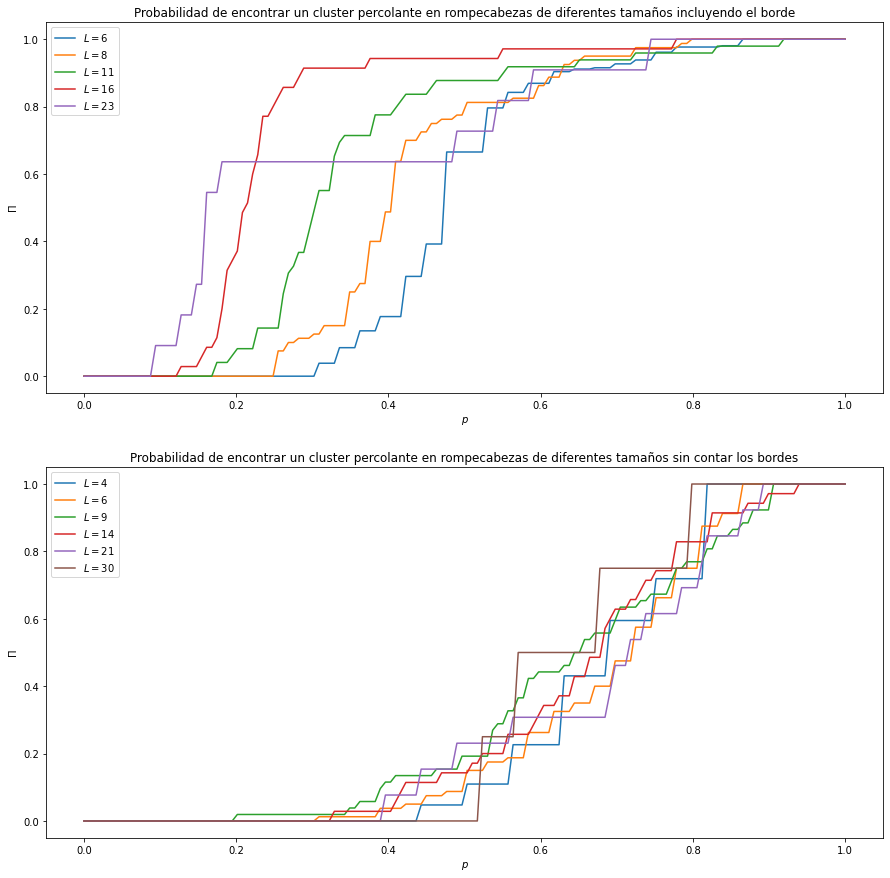

In [5]:
plt.figure(figsize=(15, 15))
plt.subplot(211)

for size in sorted(borders):

    steps_borders, prob_borders = analysis.get_pi_curve(borders[size])

    plt.plot(steps_borders, prob_borders, label=rf"$L = {size}$")

plt.xlabel(r"$p$")
plt.ylabel(r"$\Pi$")
plt.title(
    "Probabilidad de encontrar un cluster percolante en rompecabezas de diferentes tamaños incluyendo el borde"
)
plt.legend()

plt.subplot(212)
for size in sorted(no_borders):

    steps, prob = analysis.get_pi_curve(no_borders[size])

    plt.plot(steps, prob, label=rf"$L = {size}$")

plt.xlabel(r"$p$")
plt.ylabel(r"$\Pi$")
plt.title(
    "Probabilidad de encontrar un cluster percolante en rompecabezas de diferentes tamaños sin contar los bordes"
)
plt.legend()

# plt.savefig("images/compare_borders.png")

In [6]:
for size in sorted(borders):

    avg, avg_err = bootstrap(borders[size], np.mean)
    delta, delta_err = bootstrap(borders[size], np.std)

    print(f"Size {size}: Expect between {2/size} and {4/size}  real: {avg}  ")

Size 6: Expect between 0.3333333333333333 and 0.6666666666666666  real: 0.48728597222222214  
Size 8: Expect between 0.25 and 0.5  real: 0.4270631640625  
Size 11: Expect between 0.18181818181818182 and 0.36363636363636365  real: 0.34889622195985837  
Size 16: Expect between 0.125 and 0.25  real: 0.2382507700892857  
Size 23: Expect between 0.08695652173913043 and 0.17391304347826086  real: 0.30620230280116856  


In [7]:
student_t = np.loadtxt("data/student_t.txt")

def get_confidence_factor(t_value: int) -> float:
    if t_value >= len(student_t):
        return student_t[-1]
    
    return student_t[t_value-1]

In [8]:
data_no_borders = {}
for size in sorted(no_borders):

    avg, avg_err = bootstrap(no_borders[size], np.mean)
    delta, delta_err = bootstrap(no_borders[size], np.std)

    avg_err = get_confidence_factor(len(no_borders[size])) * avg_err
    delta_err = get_confidence_factor(len(no_borders[size])) * delta_err

    data_no_borders[size] ={
        "delta": delta,
        "delta_err": delta_err,
        "avg": avg,
        "avg_err": avg_err,
    } 

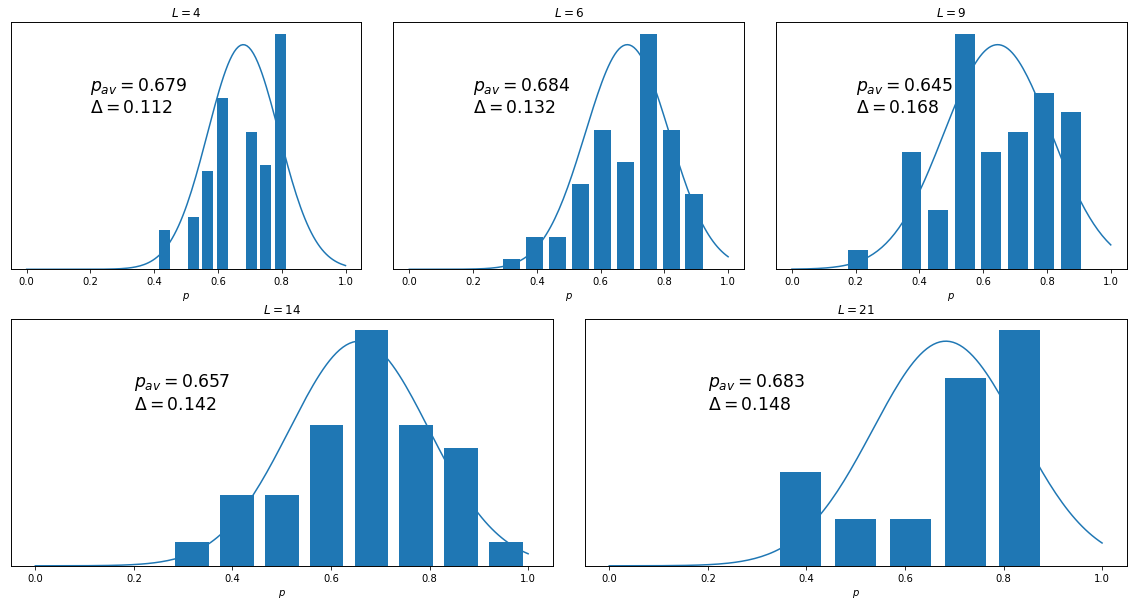

In [9]:
sizes = [4, 6, 9, 14, 21]
positions = [(1, 2), (3, 4), (5, 6), (7, 9), (10, 12)]
fig = plt.figure(figsize=(20, 10))

for i, size in enumerate(sizes):
    ax1 = plt.subplot(2, 6, positions[i])
    ax1.hist(
        no_borders[size],
        bins=int(np.round(np.sqrt(len(no_borders[size])) + 5)),
        # bins= 8,
        # bins=size**2,
        range=(0,1),
        density=True,
        # histtype="step",
        rwidth=0.75
    )
    ax1.set_xlabel(r"$p$")
    ax1.set_yticks([], [])

    steps = np.linspace(0, 1, 150)
    ax2 = ax1.twinx()

    ax2.plot(steps, analysis.gaussian(steps, data_no_borders[size]["avg"], data_no_borders[size]["delta"]))
    ax2.set_ylim(0, 1.1)
    ax2.set_yticks([], [])
    ax2.text(0.2, 0.8, rf"$p_{{av}} = {data_no_borders[size]['avg'].round(3)}$", fontsize="xx-large")
    ax2.text(0.2, 0.7, rf"$\Delta = {data_no_borders[size]['delta'].round(3)}$", fontsize="xx-large")

    plt.title(rf"$L = {size}$")
    
# fig.suptitle("Distribuciones de los puntos en los que aparece el cluster percolante para multiples tamaños de sistema")
plt.savefig("images/jigsaw_distributions.png")

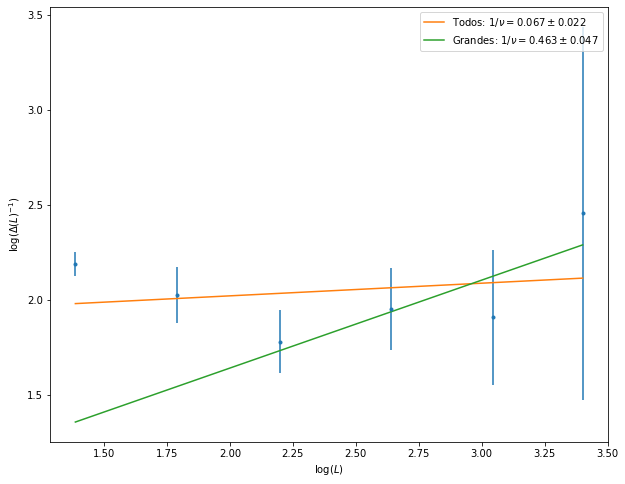

In [10]:
log_l = [np.log(size) for size in data_no_borders]
log_delta = [np.log(1 / data_no_borders[size]["delta"]) for size in data_no_borders]
log_err = [
    np.abs(-1 * data_no_borders[size]["delta_err"] / data_no_borders[size]["delta"])
    for size in data_no_borders
]

plt.figure(figsize=(10, 8))

# All points

linear_model_all, slope_err_all, intercept_err_all = analysis.linear_fit_error(
    log_l[:], log_delta[:], y_err=log_err[:]
)
lin_func_all = np.poly1d(linear_model_all)

# Largest points
linear_model_big, slope_err_big, intercept_err_big = analysis.linear_fit_error(
    log_l[2:], log_delta[2:], y_err=log_err[2:]
)
lin_func_big = np.poly1d(linear_model_big)

plt.errorbar(log_l, log_delta, yerr=log_err, linestyle="none", marker=".")
plt.plot(
    log_l,
    lin_func_all(log_l),
    label=rf"Todos: $1 / \nu= {linear_model_all[0].round(3)} \pm {slope_err_all.round(3)}$",
)
plt.plot(
    log_l,
    lin_func_big(log_l),
    label=rf"Grandes: $1 / \nu= {linear_model_big[0].round(3)} \pm {slope_err_big.round(3)}$",
)
plt.xlabel(r"$\log (L)$")
plt.ylabel(r"$\log ( \Delta(L)^{-1})$")
plt.legend()

plt.savefig("images/nu_jigsaw.png")


0.10060598847270404 0.01569261998542783


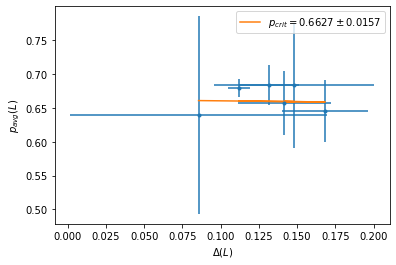

In [11]:
delta = [data_no_borders[size]["delta"] for size in data_no_borders]
avg = [data_no_borders[size]["avg"] for size in data_no_borders]
delta_err = [data_no_borders[size]["delta_err"] for size in data_no_borders]
avg_err = [data_no_borders[size]["avg_err"] for size in data_no_borders]

linear_model, slope_err, intercept_err = analysis.linear_fit_error(
    delta[2:], avg[2:], x_err=delta_err[2:], y_err=avg_err[2:]
)
lin_func = np.poly1d(linear_model)

print(slope_err, intercept_err)

plt.close()
plt.errorbar(delta, avg, xerr=delta_err, yerr=avg_err, linestyle="none", marker=".")
plt.plot(
    delta,
    lin_func(delta),
    label=rf"$ p_{{crit}} = {linear_model[1].round(4)} \pm {intercept_err.round(4)}$",
)
plt.xlabel(r"$\Delta (L)$")
plt.ylabel(r"$p_{avg}(L)$")
plt.legend()
plt.savefig("images/crit_jigsaw.png")

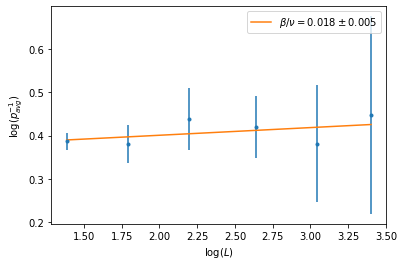

In [12]:
log_l = [np.log(size) for size in data_no_borders]
log_avg = [np.log(1 / data_no_borders[size]["avg"]) for size in data_no_borders]
log_err = [
    np.abs(-1 * data_no_borders[size]["avg_err"] / data_no_borders[size]["avg"])
    for size in data_no_borders
]

linear_model, slope_err, intercept_err = analysis.linear_fit_error(
    log_l[:], log_avg[:], y_err=log_err[:]
)
lin_func = np.poly1d(linear_model)

plt.close()
plt.errorbar(log_l, log_avg, yerr=log_err, linestyle="none", marker=".")
plt.plot(
    log_l,
    lin_func(log_l),
    label=rf"$\beta /\nu= {linear_model[0].round(3)} \pm {slope_err.round(3)}$",
)
plt.xlabel(r"$\log (L)$")
plt.ylabel(r"$\log ( p_{avg}^{-1})$")
plt.legend()
plt.savefig("images/beta_jigsaw.png")